# **Fake News Detection**

## Table of contents
* [Imports](#imports)
* [Data analysis](#data-analysis)
    * [WELFake](#2.1)
    * [Fake_news_net](#2.2)
    * [Fake True](#2.3)
* [Data preprocessing](#3)
    * [WELFake](#3.1)
        * [Bag of words](#3.1.1)
        * [Word 2 vec](#3.1.2)
        * [Split data](#3.1.3)
    * [Fake_news_net](#3.2)
        * [Bag of words](#3.2.1)
        * [Word 2 vec](#3.2.2)
        * [Split data](#3.2.3)
    * [Fake True](#3.3)
        * [Bag of words](#3.3.1)
        * [Word 2 vec](#3.3.2)
        * [Split data](#3.3.3)
* [Models](#4)
    * [WELFake](#4.1)
        * [Bag of words](#4.1.1)
        * [Word 2 vec](#4.1.2)
    * [Fake_news_net](#4.2)
        * [Bag of words](#4.2.1)
        * [Word 2 vec](#4.2.2)
    * [Fake True](#4.3)
        * [Bag of words](#4.3.1)
        * [Word 2 vec](#4.3.2)
* [Hyparameters tunning](#5)
    * [WELFake](#5.1)
        * [Bag of words](#5.1.1)
        * [Word 2 vec](#5.1.2)
    * [Fake_news_net](#5.2)
        * [Bag of words](#5.2.1)
        * [Word 2 vec](#5.2.2)
    * [Fake True](#5.3)
        * [Bag of words](#5.3.1)
        * [Word 2 vec](#5.3.2)
* [Cross-validation](#6)
    * [WELFake](#6.1)
        * [Bag of words](#6.1.1)
        * [Word 2 vec](#6.1.2)
    * [Fake_news_net](#6.2)
        * [Bag of words](#6.2.1)
        * [Word 2 vec](#6.2.2)
    * [Fake True](#6.3)
        * [Bag of words](#6.3.1)
        * [Word 2 vec](#6.3.2)

# **1. Imports** <a name="imports"></a>

In [1]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import nltk
import optuna

import torch
import torch.nn as nn
import torch.optim as optim

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

from ydata_profiling import ProfileReport
from wordcloud import WordCloud
from gensim.models import Word2Vec
from tqdm import tqdm


nltk.download('stopwords')
nltk.download('wordnet')

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/przemek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/przemek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
wel_fake = pd.read_csv('data/WELFake_Dataset.csv', index_col = 0)
fake_news_net = pd.read_csv('data/FakeNewsNet.csv', index_col=False)
true = pd.read_csv('data/true.csv', index_col=False)
fake = pd.read_csv('data/fake.csv', index_col=False)

# **2. Data analysis** <a name="data-analysis"></a>

In [3]:
def balance_plot(df, label, plot_name):
    df.groupby(label)[label].count().plot(kind='pie', autopct='%1.1f%%', title=plot_name)

In [4]:
stopwords = set(stopwords.words('english'))
def word_cloud_plot(df, groupby, agg_column):
    wc = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df.groupby(groupby)[agg_column].sum()[0])
    plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## **2.1 WEL Fake dataset** <a name="2.1"></a>

In [5]:
wel_fake

title  \
0      LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                    NaN   
2      UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3      Bobby Jindal, raised Hindu, uses story of Chri...   
4      SATAN 2: Russia unvelis an image of its terrif...   
...                                                  ...   
72129  Russians steal research on Trump in hack of U....   
72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132  Trump tussle gives unpopular Mexican leader mu...   
72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
0      No comment is expected from Barack Obama Membe...      1  
1         Did they post their votes for Hillary already?      1  
2       Now, most of the demonstrators gathered last ...      1  
3      A dozen politically active pastors came here f...      0  
4      The RS-28 Sarmat missile, dubbed Satan 2, will...      1  
...                                                  ...    ...  
72129  WASHINGTON (Reuters) - Hackers believed to be ...      0  
72130  You know, because in fantasyland Republicans n...      1  
72131  Migrants Refuse To Leave Train At Refugee Camp...      0  
72132  MEXICO CITY (Reuters) - Donald Trump’s combati...      0  
72133  Goldman Sachs Endorses Hillary Clinton For Pre...      1  

[72134 rows x 3 columns]

In [6]:
#ProfileReport(wel_fake, title='WELFake').to_file('WELFake.html')

In [7]:
missing_values = wel_fake.isnull().sum()
missing_values

title    558
text      39
label      0
dtype: int64

In [8]:
wel_fake.fillna(" ", inplace=True)
wel_fake.dropna(inplace=True)
wel_fake = wel_fake.reset_index(drop=True)

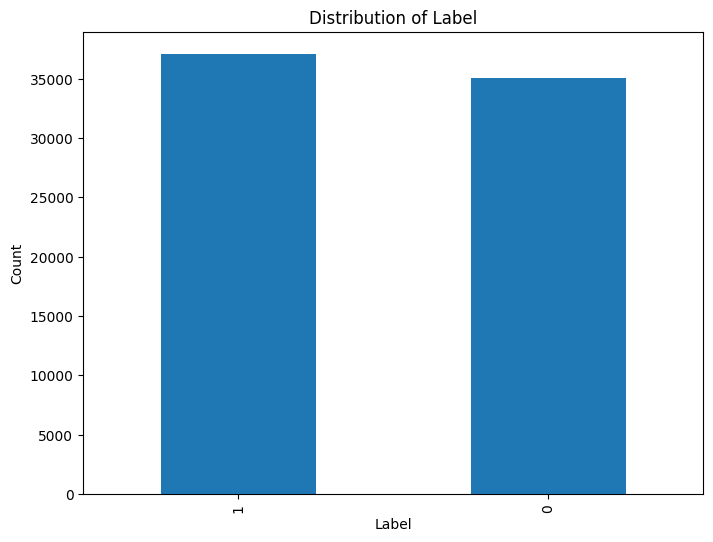

In [9]:
plt.figure(figsize=(8, 6))
wel_fake['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Label')
plt.show()

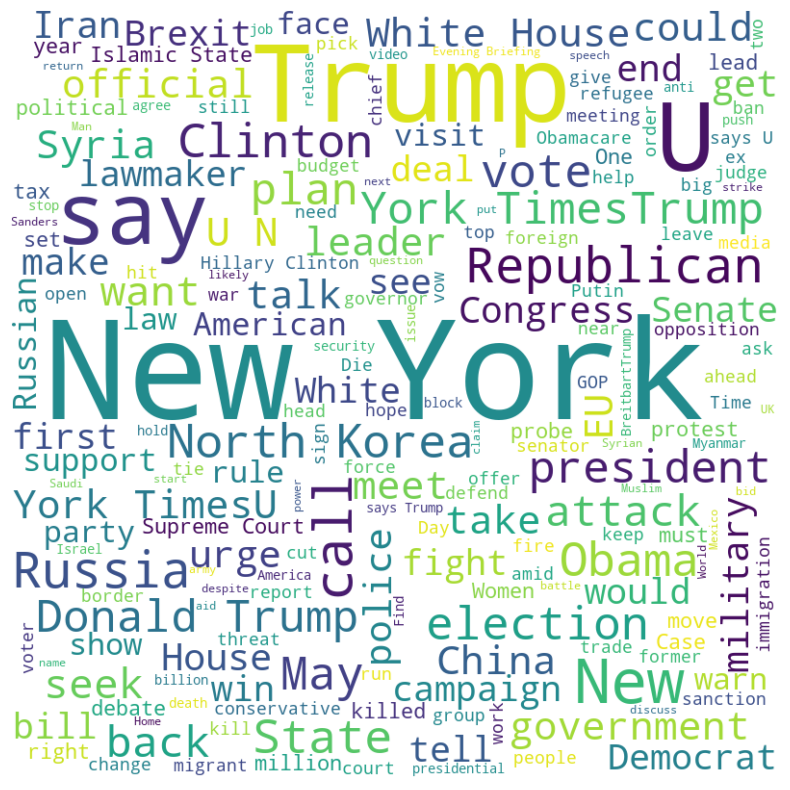

In [10]:
word_cloud_plot(wel_fake,'label', 'title')

## **2.2 Fake news net dataset** <a name="2.2"></a>

In [11]:
fake_news_net

title  \
0      Kandi Burruss Explodes Over Rape Accusation on...   
1      People's Choice Awards 2018: The best red carp...   
2      Sophia Bush Sends Sweet Birthday Message to 'O...   
3      Colombian singer Maluma sparks rumours of inap...   
4      Gossip Girl 10 Years Later: How Upper East Sid...   
...                                                  ...   
23191  Pippa Middleton wedding: In case you missed it...   
23192  Zayn Malik & Gigi Hadid’s Shocking Split: Why ...   
23193  Jessica Chastain Recalls the Moment Her Mother...   
23194  Tristan Thompson Feels "Dumped" After Khloé Ka...   
23195  Kelly Clarkson Performs a Medley of Kendrick L...   

                                                news_url  \
0      http://toofab.com/2017/05/08/real-housewives-a...   
1      https://www.today.com/style/see-people-s-choic...   
2      https://www.etonline.com/news/220806_sophia_bu...   
3      https://www.dailymail.co.uk/news/article-33655...   
4      https://www.zerchoo.com/entertainment/gossip-g...   
...                                                  ...   
23191  https://www.express.co.uk/news/royal/807049/pi...   
23192  hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...   
23193  http://www.justjared.com/2018/01/17/jessica-ch...   
23194  www.intouchweekly.com/posts/tristan-thompson-f...   
23195  https://www.billboard.com/articles/news/bbma/8...   

               source_domain  tweet_num  real  
0                 toofab.com         42     1  
1              www.today.com          0     1  
2           www.etonline.com         63     1  
3        www.dailymail.co.uk         20     1  
4            www.zerchoo.com         38     1  
...                      ...        ...   ...  
23191      www.express.co.uk         52     1  
23192      hollywoodlife.com          7     0  
23193      www.justjared.com         26     1  
23194  www.intouchweekly.com         24     0  
23195      www.billboard.com         85     1  

[23196 rows x 5 columns]

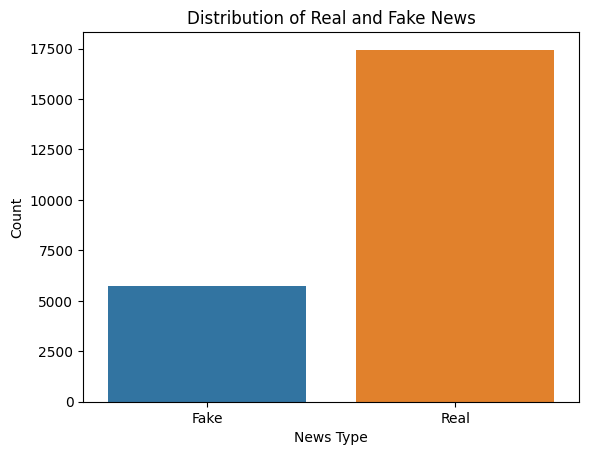

In [12]:
sns.countplot(x='real', data=fake_news_net)
plt.title('Distribution of Real and Fake News')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

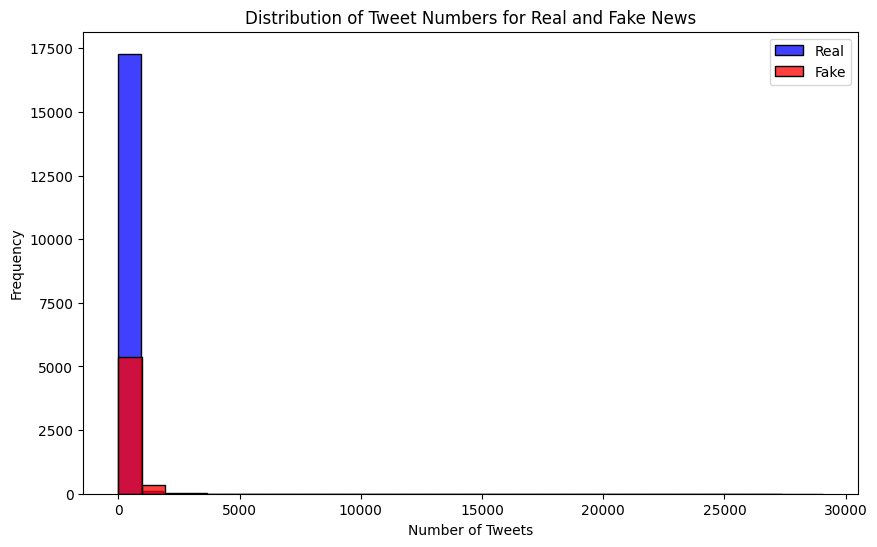

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(fake_news_net[fake_news_net['real'] == 1]['tweet_num'], bins=30, color='blue', label='Real')
sns.histplot(fake_news_net[fake_news_net['real'] == 0]['tweet_num'], bins=30, color='red', label='Fake')
plt.title('Distribution of Tweet Numbers for Real and Fake News')
plt.xlabel('Number of Tweets')
plt.ylabel('Frequency')
plt.legend()
plt.show()

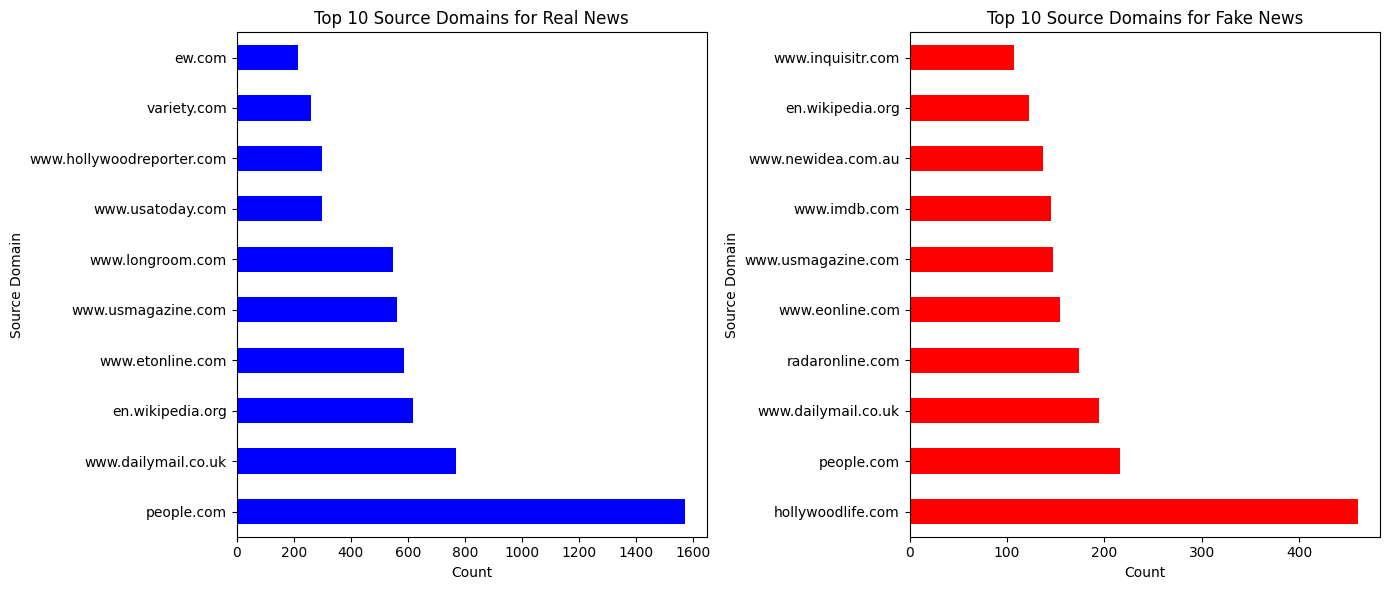

In [14]:
# Top 10 source domains for real and fake news
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
fake_news_net[fake_news_net['real'] == 1]['source_domain'].value_counts().head(10).plot(kind='barh', color='blue')
plt.title('Top 10 Source Domains for Real News')
plt.xlabel('Count')
plt.ylabel('Source Domain')

plt.subplot(1, 2, 2)
fake_news_net[fake_news_net['real'] == 0]['source_domain'].value_counts().head(10).plot(kind='barh', color='red')
plt.title('Top 10 Source Domains for Fake News')
plt.xlabel('Count')
plt.ylabel('Source Domain')

plt.tight_layout()
plt.show()

In [15]:
fake_news_net.isnull().sum()

title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64

In [16]:
#ProfileReport(fake_news_net, title='FakeNewsNet').to_file('FakeNewsNet.html')

Shape after removing missing values: (22866, 5)
Shape of balanced dataset: (10990, 5)


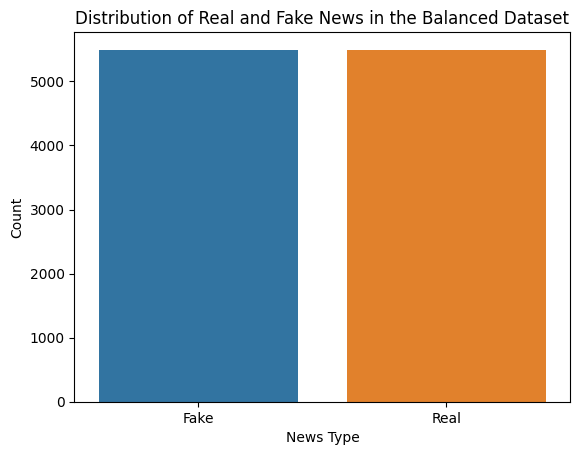

In [17]:
fake_news_net = fake_news_net.dropna()

print('Shape after removing missing values:', fake_news_net.shape)

real_news = fake_news_net[fake_news_net['real'] == 1]
fake_news = fake_news_net[fake_news_net['real'] == 0]

real_news_downsampled = real_news.sample(len(fake_news), random_state=1)

fake_news_net_balanced = pd.concat([real_news_downsampled, fake_news])

print('Shape of balanced dataset:', fake_news_net_balanced.shape)

sns.countplot(x='real', data=fake_news_net_balanced)
plt.title('Distribution of Real and Fake News in the Balanced Dataset')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

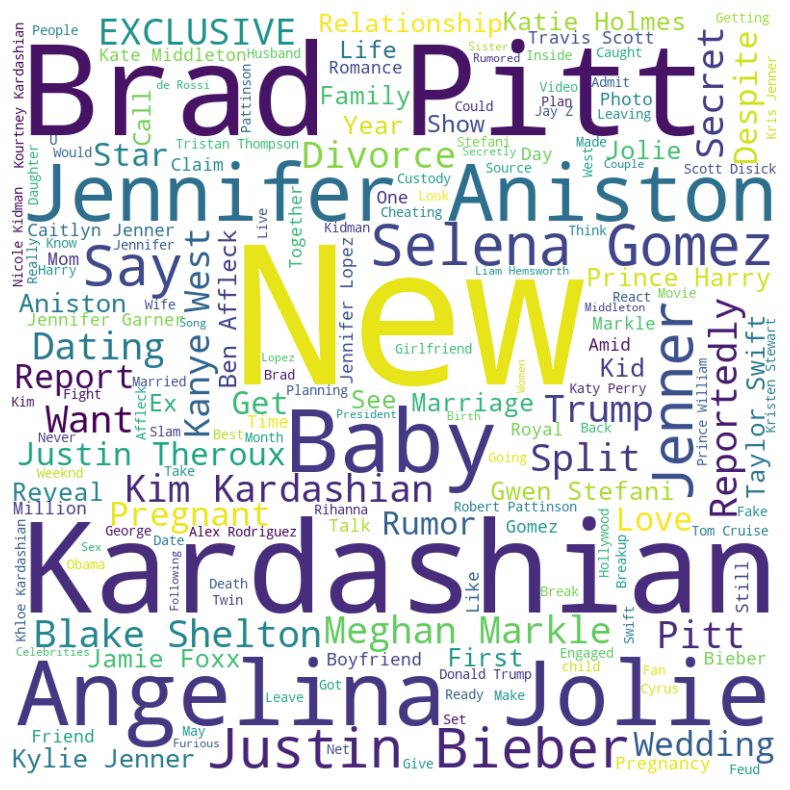

In [18]:
word_cloud_plot(fake_news_net,'real', 'title')

In [19]:
fake_news_net = fake_news_net_balanced

## **2.3 Fake and True dataset** <a name="2.3"></a>

In [20]:
fake['label'] = 0

true['label'] = 1

In [21]:
fake_true = pd.concat([fake, true]).reset_index(drop=True)

In [22]:
#ProfileReport(fake_true, title='FakeTrue').to_file('FakeTrue.html')

In [23]:
fake_true

title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
44893  'Fully committed' NATO backs new U.S. approach...   
44894  LexisNexis withdrew two products from Chinese ...   
44895  Minsk cultural hub becomes haven from authorities   
44896  Vatican upbeat on possibility of Pope Francis ...   
44897  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
0      Donald Trump just couldn t wish all Americans ...       News   
1      House Intelligence Committee Chairman Devin Nu...       News   
2      On Friday, it was revealed that former Milwauk...       News   
3      On Christmas day, Donald Trump announced that ...       News   
4      Pope Francis used his annual Christmas Day mes...       News   
...                                                  ...        ...   
44893  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
44894  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
44895  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
44896  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
44897  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                    date  label  
0      December 31, 2017      0  
1      December 31, 2017      0  
2      December 30, 2017      0  
3      December 29, 2017      0  
4      December 25, 2017      0  
...                  ...    ...  
44893   August 22, 2017       1  
44894   August 22, 2017       1  
44895   August 22, 2017       1  
44896   August 22, 2017       1  
44897   August 22, 2017       1  

[44898 rows x 5 columns]

In [24]:
fake_true.groupby(['subject', 'label']).count()

title   text   date
subject         label                     
Government News 0       1570   1570   1570
Middle-east     0        778    778    778
News            0       9050   9050   9050
US_News         0        783    783    783
left-news       0       4459   4459   4459
politics        0       6841   6841   6841
politicsNews    1      11272  11272  11272
worldnews       1      10145  10145  10145

In [25]:
fake_true.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

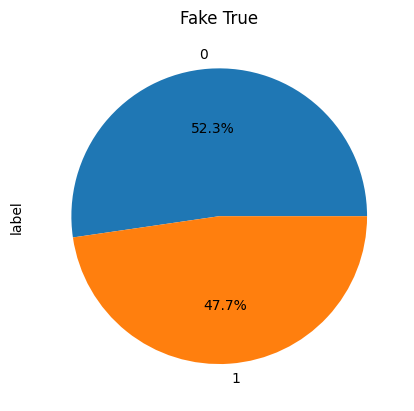

In [26]:
balance_plot(fake_true,'label', 'Fake True')

<AxesSubplot: >

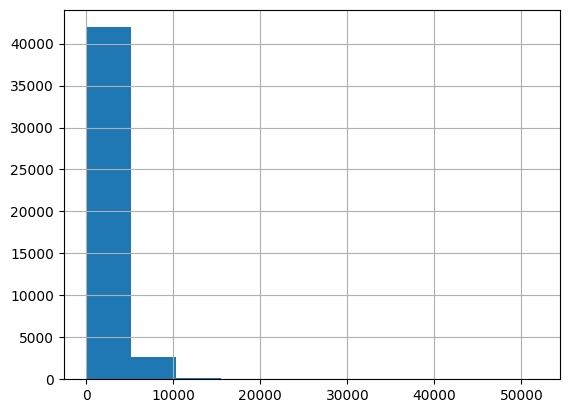

In [27]:
fake_true['text'].str.len().hist()

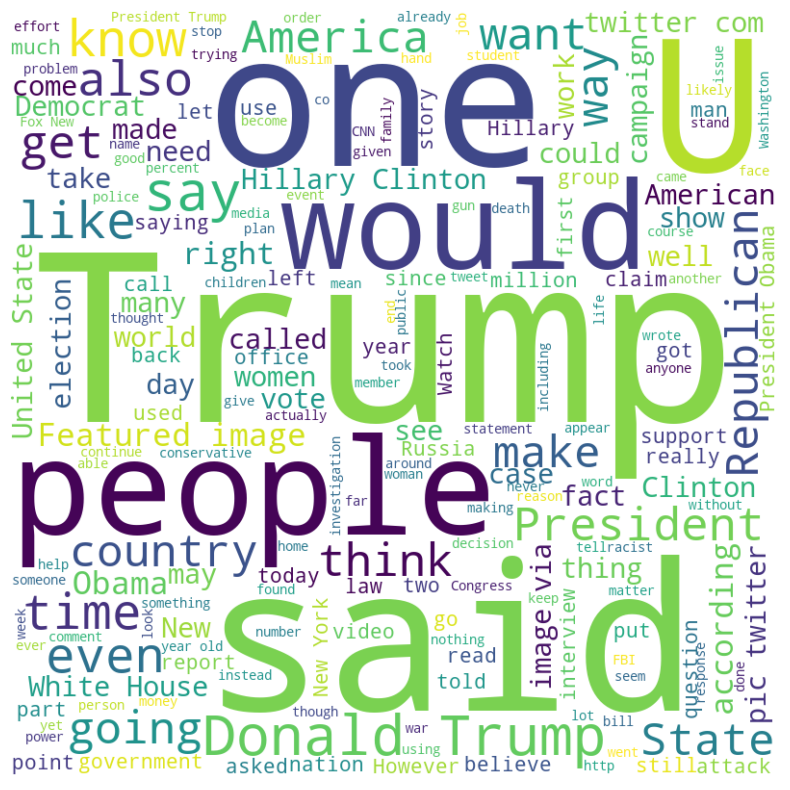

In [28]:
word_cloud_plot(fake_true,'label', 'text')

# **3. Data preprocessing** <a name="3"></a>

In [29]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]

    preprocessed_text = ' '.join(words)
    
    if preprocessed_text == "":
        preprocessed_text = "placeholder"

    return preprocessed_text

## **3.1 WEL Fake preprocessing** <a name="3.1"></a>

In [30]:
wel_fake['text'] = wel_fake['text'].apply(preprocess_text)
wel_fake.head()

title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                      
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  comment expected barack obama member # fyf911 ...      1  
1                        post vote hillary already ?      1  
2  , demonstrator gathered last night exercising ...      1  
3  dozen politically active pastor came private d...      0  
4  rs-28 sarmat missile , dubbed satan 2 , replac...      1

### **3.1.1 Bag of Words** <a name="3.1.1"></a>

In [31]:
vectorizer = CountVectorizer(min_df=2, max_features=1000)

bow = vectorizer.fit_transform(wel_fake['text'])
X_bow_wel = bow.toarray()

X_bow_wel.shape

(72134, 1000)

### **Split Data**

In [32]:
y_wel = wel_fake['label']
X_train_bow_wel, X_test_bow_wel, y_train_bow_wel, y_test_bow_wel = train_test_split(X_bow_wel, y_wel, test_size=0.2, random_state=42)
X_train_bow_wel, X_val_bow_wel, y_train_bow_wel, y_val_bow_wel = train_test_split(X_train_bow_wel, y_train_bow_wel, test_size=0.2, random_state=42)

In [33]:
y_train_bow_wel.value_counts(normalize=True) #imbalance check

1    0.514697
0    0.485303
Name: label, dtype: float64

### **3.1.2 Word 2 Vec** <a name="3.1.2"></a>

In [34]:
sentences = wel_fake['text'].apply(lambda x: x.split())
model = Word2Vec(sentences, min_count=1)

print(model)

Word2Vec<vocab=375089, vector_size=100, alpha=0.025>


In [35]:
def w2v_train_test_prepatarion(data):
    X_train_vec = [] 
    for sentence in data:
        sentence_vec = []
        for word in sentence.split():
            if word in model.wv.key_to_index:
                sentence_vec.append(model.wv[word])
            else:
                sentence_vec.append(np.zeros(100)) #100 equal to vector_size in w2v_model
        X_train_vec.append(np.mean(sentence_vec, axis=0))
    return X_train_vec

In [36]:
X_w2v_wel = w2v_train_test_prepatarion(wel_fake['text'])

In [37]:
X_w2v_wel = pd.DataFrame(X_w2v_wel)

### **3.1.3 Split Data** <a name="3.1.3"></a>

In [38]:
X_train_w2v_wel, X_test_w2v_wel, y_train_w2v_wel, y_test_w2v_wel = train_test_split(X_w2v_wel, y_wel, test_size=0.2, random_state=42)
X_train_w2v_wel, X_val_w2v_wel, y_train_w2v_wel, y_val_w2v_wel = train_test_split(X_train_w2v_wel, y_train_w2v_wel, test_size=0.2, random_state=42)

In [39]:
y_train_w2v_wel.value_counts(normalize=True) #imbalance check

1    0.514697
0    0.485303
Name: label, dtype: float64

## **3.2 Fake News Net preprocessing** <a name="3.2"></a>

In [40]:
fake_news_net['title'] = fake_news_net['title'].apply(preprocess_text)
fake_news_net.head()

title  \
6378  'battle sex ' : accurate movie infamous tennis...   
7463  watch nikki bella get swept foot male stripper...   
9916  line awful review name recognition bye bye mon...   
9866  watch : r. kelly ’ alleged hostage break silen...   
5454  james franco , actor , sexual misconduct alleg...   

                                               news_url      source_domain  \
6378  https://www.usatoday.com/story/life/movies/201...   www.usatoday.com   
7463  https://newsflash.one/2018/07/20/watch-nikki-b...      newsflash.one   
9916  http://www.foxella.com/the-line-has-awful-revi...    www.foxella.com   
9866  https://theboxhouston.com/9747399/watch-r-kell...  theboxhouston.com   
5454  https://www.vox.com/a/sexual-harassment-assaul...        www.vox.com   

      tweet_num  real  
6378          0     1  
7463         10     1  
9916          0     1  
9866         18     1  
5454         19     1

### 3.2.1 Bag of Words <a name="3.2.1"></a>

In [41]:
vectorizer = CountVectorizer(min_df=2, max_features=1000)

bow = vectorizer.fit_transform(fake_news_net['title'])
X_bow_net = bow.toarray()

X_bow_net.shape

(10990, 1000)

In [42]:
y_net = fake_news_net['real']
X_train_bow_net, X_test_bow_net, y_train_bow_net, y_test_bow_net = train_test_split(X_bow_net, y_net, test_size=0.2, random_state=42)
X_train_bow_net, X_val_bow_net, y_train_bow_net, y_val_bow_net = train_test_split(X_train_bow_net, y_train_bow_net, test_size=0.2, random_state=42)

In [43]:
y_train_bow_net.value_counts(normalize=True) #imbalance check

1    0.505901
0    0.494099
Name: real, dtype: float64

### **3.2.2 Bag of Word 2 Vec** <a name="3.2.2"></a>

In [44]:
sentences = fake_news_net['title'].apply(lambda x: x.split())
model = Word2Vec(sentences, min_count=1)

print(model)

Word2Vec<vocab=12612, vector_size=100, alpha=0.025>


In [45]:
X_w2v_net = w2v_train_test_prepatarion(fake_news_net['title'])

### 3.2.3 Split Data <a name="3.2.3"></a>

In [46]:
X_train_w2v_net, X_test_w2v_net, y_train_w2v_net, y_test_w2v_net = train_test_split(X_w2v_net, y_net, test_size=0.2, random_state=42)
X_train_w2v_net, X_val_w2v_net, y_train_w2v_net, y_val_w2v_net = train_test_split(X_train_w2v_net, y_train_w2v_net, test_size=0.2, random_state=42)

In [47]:
y_train_w2v_net.value_counts(normalize=True) #imbalance check

1    0.505901
0    0.494099
Name: real, dtype: float64

## **3.3 Fake and True preprocessing** <a name="3.3"></a>

In [48]:
fake_true.duplicated().sum()

209

In [49]:
fake_true.drop_duplicates(inplace=True)

In [50]:
fake_true['text'] = fake_true['text'].apply(preprocess_text)
fake_true.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  donald trump wish american happy new year leav...    News   
1  house intelligence committee chairman devin nu...    News   
2  friday , revealed former milwaukee sheriff dav...    News   
3  christmas day , donald trump announced would b...    News   
4  pope francis used annual christmas day message...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0

### **3.3.1 Bag of words** <a name="3.3.1"></a>

In [51]:
vectorizer = CountVectorizer(min_df=2, max_features=1000)

bow = vectorizer.fit_transform(fake_true['text'])
X_bow_ft = bow.toarray()

X_bow_ft.shape

(44689, 1000)

In [52]:
y = fake_true['label']
X_train_bow_ft, X_test_bow_ft, y_train_bow_ft, y_test_bow_ft = train_test_split(X_bow_ft, y, test_size=0.2, random_state=42)
X_train_bow_ft, X_val_bow_ft, y_train_bow_ft, y_val_bow_ft = train_test_split(X_train_bow_ft, y_train_bow_ft, test_size=0.2, random_state=42)

In [53]:
y_train_bow_ft.value_counts(normalize=True) #imbalance check

0    0.52458
1    0.47542
Name: label, dtype: float64

### **3.3.2 Word 2 Vec** <a name="3.3.2"></a>

In [54]:
sentences = fake_true['text'].apply(lambda x: x.split())
model = Word2Vec(sentences, min_count=1)

print(model)

Word2Vec<vocab=217341, vector_size=100, alpha=0.025>


In [55]:
X_w2v_ft = w2v_train_test_prepatarion(fake_true['text'])

### 3.3.3 Split Data <a name="3.3.3"></a>

In [56]:
y = fake_true['label']
X_train_w2v_ft, X_test_w2v_ft,y_train_w2v_ft, y_test_w2v_ft = train_test_split(X_w2v_ft, y, test_size=0.2, random_state=42)
X_train_w2v_ft, X_val_w2v_ft,y_train_w2v_ft, y_val_w2v_ft = train_test_split(X_train_w2v_ft, y_train_w2v_ft, test_size=0.2, random_state=42)

In [57]:
y_train_w2v_ft.value_counts(normalize=True) #imbalance check

0    0.52458
1    0.47542
Name: label, dtype: float64

## 4. Models <a name="4"></a>

In [58]:
device = (
    "cuda"
    if torch.cuda.is_available() else "cpu" )
print(f"Using {device} device")

Using cpu device


In [59]:
torch.set_default_dtype(torch.float32)

In [60]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs =torch.sigmoid( self.linear(x))
        return outputs

In [61]:
def train(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (inputs, target) in tqdm(enumerate(train_loader), desc="Epoch %s: " % (epoch+1), total=train_loader.__len__()):
            inputs = inputs.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), target)
            loss.backward()
            optimizer.step()
            
        model.eval()
        valid_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, target in valid_loader:
                inputs = inputs.to(device)
                target = target.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), target)
                valid_loss += loss.item() * inputs.size(0)
                pred = (outputs > 0.5).float() 
                correct += (pred.squeeze() == target).float().sum().item()
                
        valid_loss /= len(valid_loader.dataset)
        valid_acc = correct / len(valid_loader.dataset)
        print ('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item(), valid_loss, valid_acc))

In [62]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, target in data_loader:
            inputs = inputs.to(device)
            target = target.to(device)
            outputs = model(inputs)
            pred = (outputs > 0.5).float() 
            predictions.append(pred.squeeze().cpu().numpy())
    predictions = np.concatenate(predictions)
    return predictions

In [63]:
class LoadDataset(Dataset): #created due to lack of memory
    def __init__(self, X, y, use_toarray=False):
        self.X = X
        self.y = y
        self.use_toarray = use_toarray

    def __getitem__(self, index):
        if self.use_toarray:
            X_dense = torch.tensor(self.X[index]).float()
        else:
            X_dense = torch.tensor(self.X.iloc[index]).float()
        y_dense = torch.tensor(self.y.iloc[index]).float()
        return X_dense, y_dense

    def __len__(self):
        return len(self.y)

In [64]:
lr=0.01
epochs_num=2
criterion = nn.BCELoss()

## 4.1 WELFake <a name="4.1"></a>

### 4.1.1 Bag of Words <a name="4.1.1"></a>

In [65]:
y_train_bow_wel = y_train_bow_wel.reset_index(drop=True)
y_val_bow_wel = y_val_bow_wel.reset_index(drop=True)
y_test_bow_wel = y_test_bow_wel.reset_index(drop=True)

In [66]:
valid_loader = LoadDataset(X_val_bow_wel, y_val_bow_wel, use_toarray=True)
val_loader_bow_wel= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_bow_wel, y_train_bow_wel, use_toarray=True)
train_loader_bow_wel= DataLoader(train_loader, 
                             batch_size=32, 
                             shuffle=True)

In [67]:
model_bow_wel = LogisticRegression(input_dim=X_train_bow_wel.shape[1], output_dim=1)
model_bow_wel.to(device)
optimizer = torch.optim.Adam(model_bow_wel.parameters(), lr=lr)

In [68]:
%%time
train(model_bow_wel, train_loader_bow_wel, val_loader_bow_wel, criterion, optimizer, device, epochs_num)

Epoch 1: 100%|████████████████████████████| 1443/1443 [00:00<00:00, 1767.07it/s]


Epoch [1/2], Loss: 0.1455, Validation Loss: 0.2692, Validation Accuracy: 0.9343


Epoch 2: 100%|████████████████████████████| 1443/1443 [00:00<00:00, 2054.53it/s]


Epoch [2/2], Loss: 0.0856, Validation Loss: 0.2618, Validation Accuracy: 0.9369
CPU times: user 1.71 s, sys: 114 ms, total: 1.82 s
Wall time: 1.86 s


In [69]:
test_loader = LoadDataset(X_test_bow_wel, y_test_bow_wel, use_toarray=True)
test_loader_wel= DataLoader(test_loader, batch_size=32)

In [70]:
y_pred_wel = predict(model_bow_wel, test_loader_wel)

print(classification_report(y_test_bow_wel, y_pred_wel))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7089
           1       0.94      0.94      0.94      7338

    accuracy                           0.94     14427
   macro avg       0.94      0.94      0.94     14427
weighted avg       0.94      0.94      0.94     14427



### 4.1.2 Word 2 vec <a name="4.1.2"></a>

In [71]:
y_train_w2v_wel = y_train_w2v_wel.reset_index(drop=True)
y_val_w2v_wel = y_val_w2v_wel.reset_index(drop=True)
y_test_w2v_wel = y_test_w2v_wel.reset_index(drop=True)

In [72]:
valid_loader = LoadDataset(X_val_w2v_wel, y_val_w2v_wel)
val_loader_w2v_wel= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_w2v_wel, y_train_w2v_wel)
train_loader_w2v_wel= DataLoader(train_loader, 
                                 batch_size=32, 
                                 shuffle=True)

In [73]:
model_w2v_wel = LogisticRegression(input_dim=100, output_dim=1)
model_w2v_wel.to(device)
optimizer = torch.optim.Adam(model_w2v_wel.parameters(), lr=lr)

In [74]:
train(model_w2v_wel, train_loader_w2v_wel, val_loader_w2v_wel,  criterion, optimizer, device, epochs_num)

Epoch 1: 100%|█████████████████████████████| 1443/1443 [00:07<00:00, 202.83it/s]


Epoch [1/2], Loss: 0.2476, Validation Loss: 0.2138, Validation Accuracy: 0.9190


Epoch 2: 100%|█████████████████████████████| 1443/1443 [00:06<00:00, 207.31it/s]


Epoch [2/2], Loss: 0.0808, Validation Loss: 0.1941, Validation Accuracy: 0.9266


In [75]:
test_loader = LoadDataset(X_test_w2v_wel, y_test_w2v_wel)
test_loader_w2v= DataLoader(test_loader, batch_size=32)

In [76]:
y_pred_w2v = predict(model_w2v_wel, test_loader_w2v)

print(classification_report(y_test_w2v_wel, y_pred_w2v))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      7089
           1       0.93      0.92      0.93      7338

    accuracy                           0.93     14427
   macro avg       0.93      0.93      0.93     14427
weighted avg       0.93      0.93      0.93     14427



## 4.2 Fake_news_net <a name="4.2"></a>

### 4.2.1 Bag of words <a name="4.2.1"></a>

In [77]:
y_train_bow_net = y_train_bow_net.reset_index(drop=True)
y_val_bow_net = y_val_bow_net.reset_index(drop=True)
y_test_bow_net = y_test_bow_net.reset_index(drop = True)

In [78]:
valid_loader = LoadDataset(X_val_bow_net, y_val_bow_net, use_toarray=True)
val_loader_bow_net= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_bow_net, y_train_bow_net, use_toarray=True)
train_loader_bow_net= DataLoader(train_loader, 
                             batch_size=32, 
                             shuffle=True)

In [79]:
model_bow_net = LogisticRegression(input_dim=X_train_bow_net.shape[1], output_dim=1)
model_bow_net.to(device)
optimizer = torch.optim.Adam(model_bow_net.parameters(), lr=lr)

In [80]:
%%time
train(model_bow_net, train_loader_bow_net, val_loader_bow_net, criterion, optimizer, device, epochs_num)

Epoch 1: 100%|██████████████████████████████| 220/220 [00:00<00:00, 2003.38it/s]


Epoch [1/2], Loss: 0.4751, Validation Loss: 0.5105, Validation Accuracy: 0.7459


Epoch 2: 100%|██████████████████████████████| 220/220 [00:00<00:00, 2020.20it/s]

Epoch [2/2], Loss: 0.5751, Validation Loss: 0.4916, Validation Accuracy: 0.7567
CPU times: user 264 ms, sys: 3.13 ms, total: 267 ms
Wall time: 267 ms


In [81]:
test_loader = LoadDataset(X_test_bow_net, y_test_bow_net, use_toarray=True)
test_loader_net= DataLoader(test_loader, 
                            batch_size=32, 
                            shuffle=False)

In [82]:
y_pred_net = predict(model_bow_net, test_loader_net)

print(classification_report(y_test_bow_net, y_pred_net))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1094
           1       0.73      0.79      0.75      1104

    accuracy                           0.74      2198
   macro avg       0.75      0.74      0.74      2198
weighted avg       0.74      0.74      0.74      2198



### 4.2.2 Word 2 vec <a name="4.2.2"></a>

In [83]:
y_train_w2v_net = y_train_w2v_net.reset_index(drop=True)
y_val_w2v_net = y_val_w2v_net.reset_index(drop=True)
y_test_w2v_net = y_test_w2v_net.reset_index(drop = True)

In [84]:
valid_loader = LoadDataset(X_val_w2v_net, y_val_w2v_net, use_toarray=True)
val_loader_w2v_net= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_w2v_net, y_train_w2v_net, use_toarray=True)
train_loader_w2v_net= DataLoader(train_loader, 
                             batch_size=32, 
                             shuffle=True)

In [85]:
model_w2v_net = LogisticRegression(input_dim=100, output_dim=1)
model_w2v_net.to(device)
optimizer = torch.optim.Adam(model_w2v_net.parameters(), lr=lr)

In [86]:
%%time
train(model_w2v_net, train_loader_w2v_net, val_loader_w2v_net, criterion, optimizer, device, epochs_num)

Epoch 1: 100%|██████████████████████████████| 220/220 [00:00<00:00, 2320.43it/s]


Epoch [1/2], Loss: 0.6394, Validation Loss: 0.6441, Validation Accuracy: 0.5668


Epoch 2: 100%|██████████████████████████████| 220/220 [00:00<00:00, 2314.28it/s]

Epoch [2/2], Loss: 0.6720, Validation Loss: 0.6364, Validation Accuracy: 0.6231
CPU times: user 228 ms, sys: 2.65 ms, total: 231 ms
Wall time: 231 ms


In [87]:
test_loader = LoadDataset(X_test_w2v_net, y_test_w2v_net, use_toarray=True)
test_loader_net= DataLoader(test_loader, 
                            batch_size=32, 
                            shuffle=False)

In [88]:
y_pred_net = predict(model_w2v_net, test_loader_net)

print(classification_report(y_test_w2v_net, y_pred_net))

              precision    recall  f1-score   support

           0       0.67      0.51      0.58      1094
           1       0.61      0.75      0.67      1104

    accuracy                           0.63      2198
   macro avg       0.64      0.63      0.63      2198
weighted avg       0.64      0.63      0.63      2198



## 4.3 Fake True <a name="4.3"></a>

### 4.3.1 Bag of words <a name="4.3.1"></a>

In [89]:
y_train_bow_ft = y_train_bow_ft.reset_index(drop=True)
y_val_bow_ft = y_val_bow_ft.reset_index(drop=True)
y_test_bow_ft = y_test_bow_ft.reset_index(drop=True)


In [90]:
valid_loader = LoadDataset(X_val_bow_ft, y_val_bow_ft, use_toarray=True)
val_loader_bow_ft= DataLoader(valid_loader, 
                          batch_size=32, 
                          shuffle=True)

train_loader = LoadDataset(X_train_bow_ft, y_train_bow_ft, use_toarray=True)
train_loader_bow_ft= DataLoader(train_loader, 
                            batch_size=32, 
                            shuffle=True)

In [91]:
model_bow_ft = LogisticRegression(input_dim=X_train_bow_ft.shape[1], output_dim=1)
model_bow_ft.to(device)
optimizer = torch.optim.Adam(model_bow_ft.parameters(), lr=lr)

In [92]:
%%time
train(model_bow_ft, train_loader_bow_ft, val_loader_bow_ft, criterion, optimizer, device, epochs_num)

Epoch 1: 100%|██████████████████████████████| 894/894 [00:00<00:00, 1951.13it/s]


Epoch [1/2], Loss: 0.0091, Validation Loss: 0.0377, Validation Accuracy: 0.9912


Epoch 2: 100%|██████████████████████████████| 894/894 [00:00<00:00, 2042.48it/s]


Epoch [2/2], Loss: 0.0027, Validation Loss: 0.0265, Validation Accuracy: 0.9947
CPU times: user 1.06 s, sys: 17.1 ms, total: 1.07 s
Wall time: 1.07 s


In [93]:
test_loader = LoadDataset(X_test_bow_ft, y_test_bow_ft, use_toarray=True)
test_loader_ft= DataLoader(test_loader, 
                            batch_size=32, 
                            shuffle=False)

In [94]:
y_pred_ft = predict(model_bow_ft, test_loader_ft)

print(classification_report(y_test_bow_ft, y_pred_ft))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4738
           1       0.99      0.99      0.99      4200

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



### 4.3.2 Word 2 vec <a name="4.3.2"></a>

In [95]:
y_train_w2v_ft = y_train_w2v_ft.reset_index(drop=True)
y_val_w2v_ft = y_val_w2v_ft.reset_index(drop=True)
y_test_w2v_ft = y_test_w2v_ft.reset_index(drop = True)

In [96]:
valid_loader = LoadDataset(X_val_w2v_ft, y_val_w2v_ft, use_toarray=True)
val_loader_w2v_ft= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_w2v_ft, y_train_w2v_ft, use_toarray=True)
train_loader_w2v_ft= DataLoader(train_loader, 
                             batch_size=32, 
                             shuffle=True)

In [97]:
model_w2v_ft = LogisticRegression(input_dim=100, output_dim=1)
model_w2v_ft.to(device)
optimizer = torch.optim.Adam(model_w2v_ft.parameters(), lr=lr)

In [98]:
%%time
train(model_w2v_ft, train_loader_w2v_ft, val_loader_w2v_ft, criterion, optimizer, device, epochs_num)

Epoch 1: 100%|██████████████████████████████| 894/894 [00:00<00:00, 2339.48it/s]


Epoch [1/2], Loss: 0.0262, Validation Loss: 0.0856, Validation Accuracy: 0.9771


Epoch 2: 100%|██████████████████████████████| 894/894 [00:00<00:00, 2348.10it/s]


Epoch [2/2], Loss: 0.0576, Validation Loss: 0.0597, Validation Accuracy: 0.9845
CPU times: user 911 ms, sys: 6.04 ms, total: 918 ms
Wall time: 917 ms


In [99]:
test_loader = LoadDataset(X_test_w2v_ft, y_test_w2v_ft, use_toarray=True)
test_loader_ft= DataLoader(test_loader, 
                            batch_size=32, 
                            shuffle=False)

In [100]:
y_pred_ft = predict(model_w2v_ft, test_loader_ft)

print(classification_report(y_test_w2v_ft, y_pred_ft))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4738
           1       0.97      0.99      0.98      4200

    accuracy                           0.98      8938
   macro avg       0.98      0.98      0.98      8938
weighted avg       0.98      0.98      0.98      8938



## **5. Hyperparameters tunning** <a name="5"></a>

In [101]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-3, 1e-1)
    epochs = trial.suggest_int('epochs', 5, 50)


    model = LogisticRegression(input_dim=X, output_dim=1)
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            imputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).float().sum().item()

    return correct / total

In [102]:
def callback(study, trial):
    print("Trial finished with value: ", trial.value)

### 5.1 WELFake <a name="5.1"></a>

### 5.1.1 Bag of Words <a name="5.1.1"></a>

In [103]:
X = X_train_bow_wel.shape[1]
train_loader = train_loader_bow_wel
val_loader = val_loader_bow_wel

In [104]:
%%time
study_bow_wel = optuna.create_study(direction='maximize')
study_bow_wel.optimize(objective, n_trials=100, callbacks=[callback])

print('Best hyperparameters:', study_bow_wel.best_params)

Trial finished with value:  0.9443770577023046
Trial finished with value:  0.9366660890660198
Trial finished with value:  0.9409114538208283
Trial finished with value:  0.945936579448969
Trial finished with value:  0.94394385721712
Trial finished with value:  0.9452434586726737
Trial finished with value:  0.9371859296482412
Trial finished with value:  0.945936579448969
Trial finished with value:  0.9334604054756541
Trial finished with value:  0.9389187315889794
Trial finished with value:  0.9460232195460059
Trial finished with value:  0.9458499393519321
Trial finished with value:  0.9464564200311905
Trial finished with value:  0.9403916132386069
Trial finished with value:  0.9461964997400797
Trial finished with value:  0.9400450528504591
Trial finished with value:  0.9457632992548952
Trial finished with value:  0.9452434586726737
Trial finished with value:  0.9465430601282273
Trial finished with value:  0.9429041760526772
Trial finished with value:  0.9458499393519321
Trial finished wi

In [105]:
optuna.visualization.plot_optimization_history(study_bow_wel)

### 5.1.2 Word 2 vec <a name="5.1.2"></a>

In [106]:
X = 100
train_loader = train_loader_w2v_wel
val_loader = val_loader_w2v_wel

In [ ]:
%%time
study_w2v_wel = optuna.create_study(direction='maximize')
study_w2v_wel.optimize(objective, n_trials=100, callbacks=[callback])

print('Best hyperparameters:', study_w2v_wel.best_params)

In [108]:
optuna.visualization.plot_optimization_history(study_w2v_wel)

### 5.2 Fake_new_net <a name="5.2"></a>

### 5.2.1 Bag of Words <a name="5.2.1"></a>

In [109]:
X = X_train_bow_net.shape[1]
train_loader = train_loader_bow_net
val_loader = val_loader_bow_net

In [110]:
%%time
study_bow_net = optuna.create_study(direction='maximize')
study_bow_net.optimize(objective, n_trials=100, callbacks=[callback])

print('Best hyperparameters:', study_bow_net.best_params)

Trial finished with value:  0.7430358158044343
Trial finished with value:  0.7373507674815236
Trial finished with value:  0.7333712336554861
Trial finished with value:  0.7396247868106879
Trial finished with value:  0.7527003979533826
Trial finished with value:  0.755542922114838
Trial finished with value:  0.7407617964752701
Trial finished with value:  0.7544059124502558
Trial finished with value:  0.7407617964752701
Trial finished with value:  0.7561114269471291
Trial finished with value:  0.747583854462763
Trial finished with value:  0.7504263786242183
Trial finished with value:  0.7561114269471291
Trial finished with value:  0.7549744172825469
Trial finished with value:  0.755542922114838
Trial finished with value:  0.7458783399658897
Trial finished with value:  0.755542922114838
Trial finished with value:  0.755542922114838
Trial finished with value:  0.7538374076179648
Trial finished with value:  0.7487208641273451
Trial finished with value:  0.755542922114838
Trial finished with

In [111]:
optuna.visualization.plot_optimization_history(study_bow_net)

### 5.2.2 Word 2 vec <a name="5.2.2"></a>

In [112]:
X = 100
train_loader = train_loader_w2v_net
val_loader = val_loader_w2v_net

In [113]:
%%time
study_w2v_net = optuna.create_study(direction='maximize')
study_w2v_net.optimize(objective, n_trials=100, callbacks=[callback])

print('Best hyperparameters:', study_w2v_net.best_params)

Trial finished with value:  0.6600341102899374
Trial finished with value:  0.6520750426378624
Trial finished with value:  0.6321773735076748
Trial finished with value:  0.6372939169982945
Trial finished with value:  0.6242183058555998
Trial finished with value:  0.641841955656623
Trial finished with value:  0.6509380329732802
Trial finished with value:  0.6463899943149517
Trial finished with value:  0.6270608300170551
Trial finished with value:  0.6156907333712337
Trial finished with value:  0.6679931779420125
Trial finished with value:  0.6003411028993746
Trial finished with value:  0.6662876634451392
Trial finished with value:  0.6657191586128482
Trial finished with value:  0.6617396247868107
Trial finished with value:  0.6628766344513929
Trial finished with value:  0.6651506537805572
Trial finished with value:  0.6532120523024446
Trial finished with value:  0.6463899943149517
Trial finished with value:  0.6623081296191018
Trial finished with value:  0.6492325184764071
Trial finished

In [114]:
optuna.visualization.plot_optimization_history(study_w2v_net)

### 5.3 Fake True <a name="5.3"></a>

### 5.3.1 Bag of Words <a name="5.3.1"></a>

In [115]:
X = X_train_bow_ft.shape[1]
train_loader = train_loader_bow_ft
val_loader = val_loader_bow_ft

In [116]:
%%time
study_bow_ft = optuna.create_study(direction='maximize')
study_bow_ft.optimize(objective, n_trials=100, callbacks=[callback])

print('Best hyperparameters:', study_bow_ft.best_params)

Trial finished with value:  0.9937071738218431
Trial finished with value:  0.9955251013844217
Trial finished with value:  0.9942665361487903
Trial finished with value:  0.9956649419661586
Trial finished with value:  0.9949657390574744
Trial finished with value:  0.9955251013844217
Trial finished with value:  0.995385260802685
Trial finished with value:  0.9941266955670536
Trial finished with value:  0.9931478114948958
Trial finished with value:  0.9924486085862118
Trial finished with value:  0.9951055796392113
Trial finished with value:  0.9959446231296322
Trial finished with value:  0.9955251013844217
Trial finished with value:  0.9958047825478954
Trial finished with value:  0.9955251013844217
Trial finished with value:  0.995385260802685
Trial finished with value:  0.9958047825478954
Trial finished with value:  0.9958047825478954
Trial finished with value:  0.9951055796392113
Trial finished with value:  0.9955251013844217
Trial finished with value:  0.9959446231296322
Trial finished 

In [117]:
optuna.visualization.plot_optimization_history(study_bow_ft)

### 5.3.2 Word 2 vec <a name="5.3.2"></a>

In [118]:
X = 100
train_loader = train_loader_w2v_ft
val_loader = val_loader_w2v_ft

In [119]:
%%time
study_w2v_ft = optuna.create_study(direction='maximize')
study_w2v_ft.optimize(objective, n_trials=100, callbacks=[callback])

print('Best hyperparameters:', study_w2v_ft.best_params)

Trial finished with value:  0.9858761012445811
Trial finished with value:  0.9885330722975808
Trial finished with value:  0.9916095650957908
Trial finished with value:  0.9913298839323171
Trial finished with value:  0.9910502027688435
Trial finished with value:  0.9896517969514753
Trial finished with value:  0.9913298839323171
Trial finished with value:  0.9910502027688435
Trial finished with value:  0.9878338693888966
Trial finished with value:  0.9911900433505804
Trial finished with value:  0.9909103621871067
Trial finished with value:  0.9913298839323171
Trial finished with value:  0.991469724514054
Trial finished with value:  0.9895119563697385
Trial finished with value:  0.9896517969514753
Trial finished with value:  0.9900713186966857
Trial finished with value:  0.9876940288071598
Trial finished with value:  0.9902111592784226
Trial finished with value:  0.9904908404418963
Trial finished with value:  0.9907705216053698
Trial finished with value:  0.9911900433505804
Trial finished

In [120]:
optuna.visualization.plot_optimization_history(study_w2v_ft)

## 6. Cross-validation <a name="6"></a>

In [121]:
from sklearn.model_selection import StratifiedKFold

def train_one_fold(model, train_loader, criterion, optimizer, device):
    model.train()
    for batch_idx, (inputs, target) in tqdm(enumerate(train_loader), desc="Training: ", total=train_loader.__len__()):
        inputs = inputs.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()

def validate_one_fold(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, target in valid_loader:
            inputs = inputs.to(device)
            target = target.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), target)
            valid_loss += loss.item() * inputs.size(0)
            pred = (outputs > 0.5).float() 
            correct += (pred.squeeze() == target).float().sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_acc = correct / len(valid_loader.dataset)
    print ('Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(valid_loss, valid_acc))
    return valid_acc

def stratified_cross_validation(X, y,criterion, device, num_epochs, use):
    skf = StratifiedKFold(n_splits=5)
    acc_per_fold = []

    for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print(f"Training fold {fold+1}")
        
        X_train_fold, X_valid_fold = X[train_index], X[valid_index]
        y_train_fold, y_valid_fold = y[train_index], y[valid_index]
        
        model = LogisticRegression(input_dim=X_train_fold.shape[1], output_dim=1)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        train_dataset = LoadDataset(X_train_fold, y_train_fold, use_toarray=use)
        valid_dataset = LoadDataset(X_valid_fold, y_valid_fold, use_toarray=use)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
        
        model.to(device)
        
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}")
            train_one_fold(model, train_loader, criterion, optimizer, device)
            acc_per_fold.append(validate_one_fold(model, valid_loader, criterion, device))
    avg_acc = sum(acc_per_fold) / len(acc_per_fold)
    print('Average accuracy:', avg_acc)

### 6.1 WELFake <a name="6.1"></a> 

### 6.1.1 Bag of words <a name="6.1.1"></a>

In [122]:
lr = study_bow_wel.best_params['lr']
epochs_num = study_bow_wel.best_params['epochs']

In [123]:
stratified_cross_validation(X_bow_wel, y_wel, criterion, device, epochs_num, True)

Training fold 1
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1913.99it/s]


Validation Loss: 0.2022, Validation Accuracy: 0.9391
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2016.41it/s]


Validation Loss: 0.1755, Validation Accuracy: 0.9470
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2016.58it/s]


Validation Loss: 0.1679, Validation Accuracy: 0.9485
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2014.40it/s]


Validation Loss: 0.1648, Validation Accuracy: 0.9491
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2003.85it/s]


Validation Loss: 0.1679, Validation Accuracy: 0.9476
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2018.51it/s]


Validation Loss: 0.1666, Validation Accuracy: 0.9488
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2018.86it/s]


Validation Loss: 0.1724, Validation Accuracy: 0.9494
Training fold 2
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1908.67it/s]


Validation Loss: 0.1909, Validation Accuracy: 0.9421
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2035.58it/s]


Validation Loss: 0.1657, Validation Accuracy: 0.9478
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2018.93it/s]


Validation Loss: 0.1577, Validation Accuracy: 0.9495
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2021.33it/s]


Validation Loss: 0.1529, Validation Accuracy: 0.9515
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2023.40it/s]


Validation Loss: 0.1512, Validation Accuracy: 0.9505
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2027.40it/s]


Validation Loss: 0.1505, Validation Accuracy: 0.9509
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2028.51it/s]


Validation Loss: 0.1601, Validation Accuracy: 0.9485
Training fold 3
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1943.61it/s]


Validation Loss: 0.1999, Validation Accuracy: 0.9398
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2012.04it/s]


Validation Loss: 0.1730, Validation Accuracy: 0.9468
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2028.26it/s]


Validation Loss: 0.1639, Validation Accuracy: 0.9460
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2020.27it/s]


Validation Loss: 0.1619, Validation Accuracy: 0.9475
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2020.29it/s]


Validation Loss: 0.1603, Validation Accuracy: 0.9486
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2026.15it/s]


Validation Loss: 0.1604, Validation Accuracy: 0.9486
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2021.81it/s]


Validation Loss: 0.1605, Validation Accuracy: 0.9483
Training fold 4
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1943.87it/s]


Validation Loss: 0.2027, Validation Accuracy: 0.9412
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2012.14it/s]


Validation Loss: 0.1752, Validation Accuracy: 0.9482
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2020.82it/s]


Validation Loss: 0.1605, Validation Accuracy: 0.9498
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2018.08it/s]


Validation Loss: 0.1673, Validation Accuracy: 0.9486
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2012.10it/s]


Validation Loss: 0.1714, Validation Accuracy: 0.9493
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2007.03it/s]


Validation Loss: 0.1781, Validation Accuracy: 0.9499
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2020.25it/s]


Validation Loss: 0.1770, Validation Accuracy: 0.9497
Training fold 5
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1945.84it/s]


Validation Loss: 0.1981, Validation Accuracy: 0.9424
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2019.88it/s]


Validation Loss: 0.1714, Validation Accuracy: 0.9463
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2020.62it/s]


Validation Loss: 0.1631, Validation Accuracy: 0.9475
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2019.54it/s]


Validation Loss: 0.1603, Validation Accuracy: 0.9474
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2018.05it/s]


Validation Loss: 0.1591, Validation Accuracy: 0.9477
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2025.83it/s]


Validation Loss: 0.1594, Validation Accuracy: 0.9482
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2022.32it/s]


Validation Loss: 0.1704, Validation Accuracy: 0.9471
Average accuracy: 0.9473955115448488


### 6.1.2 Word 2 vec <a name="6.1.2"></a>

In [124]:
lr = study_w2v_wel.best_params['lr']
epochs_num = study_w2v_wel.best_params['epochs']

In [125]:
X_w2v_wel = pd.DataFrame(X_w2v_wel)

In [126]:
stratified_cross_validation(X_w2v_wel.values, y_wel, criterion, device, epochs_num, True)

Training fold 1
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2340.16it/s]


Validation Loss: 0.1921, Validation Accuracy: 0.9257
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.91it/s]


Validation Loss: 0.1877, Validation Accuracy: 0.9280
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.04it/s]


Validation Loss: 0.1850, Validation Accuracy: 0.9310
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.69it/s]


Validation Loss: 0.1854, Validation Accuracy: 0.9296
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2354.06it/s]


Validation Loss: 0.2178, Validation Accuracy: 0.9165
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.67it/s]


Validation Loss: 0.2187, Validation Accuracy: 0.9160
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2347.46it/s]


Validation Loss: 0.1839, Validation Accuracy: 0.9300
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2365.82it/s]


Validation Loss: 0.1836, Validation Accuracy: 0.9310
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.42it/s]


Validation Loss: 0.2048, Validation Accuracy: 0.9211
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.06it/s]


Validation Loss: 0.1857, Validation Accuracy: 0.9294
Epoch 11


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.44it/s]


Validation Loss: 0.1791, Validation Accuracy: 0.9316
Epoch 12


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.73it/s]


Validation Loss: 0.1806, Validation Accuracy: 0.9319
Epoch 13


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.64it/s]


Validation Loss: 0.1728, Validation Accuracy: 0.9333
Epoch 14


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2362.72it/s]


Validation Loss: 0.2291, Validation Accuracy: 0.9100
Epoch 15


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2341.53it/s]


Validation Loss: 0.1772, Validation Accuracy: 0.9319
Epoch 16


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2365.11it/s]


Validation Loss: 0.2134, Validation Accuracy: 0.9174
Epoch 17


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.81it/s]


Validation Loss: 0.1837, Validation Accuracy: 0.9315
Epoch 18


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.20it/s]


Validation Loss: 0.2023, Validation Accuracy: 0.9215
Epoch 19


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2364.33it/s]


Validation Loss: 0.1698, Validation Accuracy: 0.9353
Epoch 20


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.00it/s]


Validation Loss: 0.2099, Validation Accuracy: 0.9230
Epoch 21


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2365.61it/s]


Validation Loss: 0.1903, Validation Accuracy: 0.9302
Epoch 22


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.12it/s]


Validation Loss: 0.1922, Validation Accuracy: 0.9292
Epoch 23


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.39it/s]


Validation Loss: 0.1759, Validation Accuracy: 0.9355
Epoch 24


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.99it/s]


Validation Loss: 0.1923, Validation Accuracy: 0.9276
Epoch 25


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2361.54it/s]


Validation Loss: 0.1781, Validation Accuracy: 0.9351
Epoch 26


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.55it/s]


Validation Loss: 0.1804, Validation Accuracy: 0.9329
Epoch 27


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.12it/s]


Validation Loss: 0.2330, Validation Accuracy: 0.9139
Epoch 28


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.09it/s]


Validation Loss: 0.1778, Validation Accuracy: 0.9338
Epoch 29


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.20it/s]


Validation Loss: 0.1760, Validation Accuracy: 0.9355
Epoch 30


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.82it/s]


Validation Loss: 0.2041, Validation Accuracy: 0.9245
Epoch 31


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2359.51it/s]


Validation Loss: 0.1724, Validation Accuracy: 0.9366
Epoch 32


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.00it/s]


Validation Loss: 0.1757, Validation Accuracy: 0.9348
Epoch 33


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1970.29it/s]


Validation Loss: 0.1738, Validation Accuracy: 0.9363
Epoch 34


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2145.86it/s]


Validation Loss: 0.2063, Validation Accuracy: 0.9242
Epoch 35


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2304.98it/s]


Validation Loss: 0.2497, Validation Accuracy: 0.9075
Epoch 36


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2361.98it/s]


Validation Loss: 0.2036, Validation Accuracy: 0.9243
Epoch 37


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2351.14it/s]


Validation Loss: 0.1834, Validation Accuracy: 0.9314
Epoch 38


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.76it/s]


Validation Loss: 0.2587, Validation Accuracy: 0.9025
Epoch 39


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.64it/s]


Validation Loss: 0.1766, Validation Accuracy: 0.9349
Epoch 40


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2316.32it/s]


Validation Loss: 0.2156, Validation Accuracy: 0.9176
Epoch 41


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2297.88it/s]


Validation Loss: 0.1762, Validation Accuracy: 0.9351
Epoch 42


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2361.36it/s]


Validation Loss: 0.1782, Validation Accuracy: 0.9337
Epoch 43


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.87it/s]


Validation Loss: 0.1746, Validation Accuracy: 0.9364
Epoch 44


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.81it/s]


Validation Loss: 0.2335, Validation Accuracy: 0.9124
Epoch 45


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2362.32it/s]


Validation Loss: 0.2121, Validation Accuracy: 0.9200
Training fold 2
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.31it/s]


Validation Loss: 0.2059, Validation Accuracy: 0.9237
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.85it/s]


Validation Loss: 0.2443, Validation Accuracy: 0.9061
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2361.12it/s]


Validation Loss: 0.2098, Validation Accuracy: 0.9222
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2359.56it/s]


Validation Loss: 0.1892, Validation Accuracy: 0.9292
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.58it/s]


Validation Loss: 0.1866, Validation Accuracy: 0.9317
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.16it/s]


Validation Loss: 0.1827, Validation Accuracy: 0.9324
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.74it/s]


Validation Loss: 0.1911, Validation Accuracy: 0.9299
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.84it/s]


Validation Loss: 0.1952, Validation Accuracy: 0.9305
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.59it/s]


Validation Loss: 0.1833, Validation Accuracy: 0.9346
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.43it/s]


Validation Loss: 0.1877, Validation Accuracy: 0.9325
Epoch 11


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.59it/s]


Validation Loss: 0.1964, Validation Accuracy: 0.9260
Epoch 12


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2361.94it/s]


Validation Loss: 0.1923, Validation Accuracy: 0.9298
Epoch 13


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.22it/s]


Validation Loss: 0.1793, Validation Accuracy: 0.9351
Epoch 14


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2364.66it/s]


Validation Loss: 0.1808, Validation Accuracy: 0.9349
Epoch 15


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.57it/s]


Validation Loss: 0.1976, Validation Accuracy: 0.9328
Epoch 16


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.55it/s]


Validation Loss: 0.1856, Validation Accuracy: 0.9321
Epoch 17


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.79it/s]


Validation Loss: 0.2117, Validation Accuracy: 0.9237
Epoch 18


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.62it/s]


Validation Loss: 0.1860, Validation Accuracy: 0.9348
Epoch 19


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.32it/s]


Validation Loss: 0.1747, Validation Accuracy: 0.9374
Epoch 20


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2362.36it/s]


Validation Loss: 0.2118, Validation Accuracy: 0.9210
Epoch 21


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2351.81it/s]


Validation Loss: 0.1979, Validation Accuracy: 0.9281
Epoch 22


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.53it/s]


Validation Loss: 0.1839, Validation Accuracy: 0.9359
Epoch 23


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.86it/s]


Validation Loss: 0.1747, Validation Accuracy: 0.9369
Epoch 24


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.55it/s]


Validation Loss: 0.1889, Validation Accuracy: 0.9310
Epoch 25


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2350.15it/s]


Validation Loss: 0.1822, Validation Accuracy: 0.9325
Epoch 26


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.96it/s]


Validation Loss: 0.2208, Validation Accuracy: 0.9200
Epoch 27


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.15it/s]


Validation Loss: 0.2195, Validation Accuracy: 0.9208
Epoch 28


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2359.03it/s]


Validation Loss: 0.2010, Validation Accuracy: 0.9284
Epoch 29


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2362.81it/s]


Validation Loss: 0.1883, Validation Accuracy: 0.9315
Epoch 30


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2362.61it/s]


Validation Loss: 0.1896, Validation Accuracy: 0.9329
Epoch 31


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2354.69it/s]


Validation Loss: 0.2132, Validation Accuracy: 0.9209
Epoch 32


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2359.84it/s]


Validation Loss: 0.1870, Validation Accuracy: 0.9319
Epoch 33


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.73it/s]


Validation Loss: 0.1751, Validation Accuracy: 0.9373
Epoch 34


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.13it/s]


Validation Loss: 0.1803, Validation Accuracy: 0.9355
Epoch 35


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2364.89it/s]


Validation Loss: 0.2130, Validation Accuracy: 0.9240
Epoch 36


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.54it/s]


Validation Loss: 0.2051, Validation Accuracy: 0.9258
Epoch 37


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.51it/s]


Validation Loss: 0.1823, Validation Accuracy: 0.9387
Epoch 38


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.49it/s]


Validation Loss: 0.1834, Validation Accuracy: 0.9362
Epoch 39


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2351.10it/s]


Validation Loss: 0.1800, Validation Accuracy: 0.9352
Epoch 40


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.58it/s]


Validation Loss: 0.1810, Validation Accuracy: 0.9325
Epoch 41


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2362.13it/s]


Validation Loss: 0.1886, Validation Accuracy: 0.9337
Epoch 42


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2348.96it/s]


Validation Loss: 0.1871, Validation Accuracy: 0.9326
Epoch 43


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.27it/s]


Validation Loss: 0.2009, Validation Accuracy: 0.9287
Epoch 44


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2359.40it/s]


Validation Loss: 0.2036, Validation Accuracy: 0.9290
Epoch 45


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2361.03it/s]


Validation Loss: 0.1867, Validation Accuracy: 0.9333
Training fold 3
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.42it/s]


Validation Loss: 0.2073, Validation Accuracy: 0.9182
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.76it/s]


Validation Loss: 0.1940, Validation Accuracy: 0.9242
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2342.17it/s]


Validation Loss: 0.1847, Validation Accuracy: 0.9276
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.43it/s]


Validation Loss: 0.2375, Validation Accuracy: 0.9103
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.04it/s]


Validation Loss: 0.1856, Validation Accuracy: 0.9294
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2362.59it/s]


Validation Loss: 0.1774, Validation Accuracy: 0.9328
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.22it/s]


Validation Loss: 0.2029, Validation Accuracy: 0.9228
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.08it/s]


Validation Loss: 0.1985, Validation Accuracy: 0.9258
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2309.87it/s]


Validation Loss: 0.1777, Validation Accuracy: 0.9319
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2372.48it/s]


Validation Loss: 0.1807, Validation Accuracy: 0.9310
Epoch 11


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2333.86it/s]


Validation Loss: 0.1774, Validation Accuracy: 0.9326
Epoch 12


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.09it/s]


Validation Loss: 0.1875, Validation Accuracy: 0.9273
Epoch 13


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.74it/s]


Validation Loss: 0.1838, Validation Accuracy: 0.9311
Epoch 14


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.41it/s]


Validation Loss: 0.1821, Validation Accuracy: 0.9314
Epoch 15


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2152.48it/s]


Validation Loss: 0.1772, Validation Accuracy: 0.9319
Epoch 16


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.18it/s]


Validation Loss: 0.2058, Validation Accuracy: 0.9219
Epoch 17


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.53it/s]


Validation Loss: 0.1786, Validation Accuracy: 0.9310
Epoch 18


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.77it/s]


Validation Loss: 0.1735, Validation Accuracy: 0.9330
Epoch 19


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2359.84it/s]


Validation Loss: 0.1753, Validation Accuracy: 0.9333
Epoch 20


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2344.26it/s]


Validation Loss: 0.2243, Validation Accuracy: 0.9138
Epoch 21


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2365.18it/s]


Validation Loss: 0.1746, Validation Accuracy: 0.9340
Epoch 22


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.93it/s]


Validation Loss: 0.1997, Validation Accuracy: 0.9252
Epoch 23


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.41it/s]


Validation Loss: 0.1942, Validation Accuracy: 0.9258
Epoch 24


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.24it/s]


Validation Loss: 0.1701, Validation Accuracy: 0.9344
Epoch 25


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.65it/s]


Validation Loss: 0.1719, Validation Accuracy: 0.9357
Epoch 26


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2345.69it/s]


Validation Loss: 0.1871, Validation Accuracy: 0.9268
Epoch 27


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.21it/s]


Validation Loss: 0.1955, Validation Accuracy: 0.9255
Epoch 28


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2361.68it/s]


Validation Loss: 0.1780, Validation Accuracy: 0.9324
Epoch 29


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2361.01it/s]


Validation Loss: 0.1806, Validation Accuracy: 0.9323
Epoch 30


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.55it/s]


Validation Loss: 0.1766, Validation Accuracy: 0.9334
Epoch 31


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.85it/s]


Validation Loss: 0.2010, Validation Accuracy: 0.9220
Epoch 32


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2349.00it/s]


Validation Loss: 0.1690, Validation Accuracy: 0.9361
Epoch 33


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.89it/s]


Validation Loss: 0.1664, Validation Accuracy: 0.9371
Epoch 34


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2361.69it/s]


Validation Loss: 0.1693, Validation Accuracy: 0.9373
Epoch 35


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2354.94it/s]


Validation Loss: 0.1813, Validation Accuracy: 0.9319
Epoch 36


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.74it/s]


Validation Loss: 0.2018, Validation Accuracy: 0.9243
Epoch 37


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.73it/s]


Validation Loss: 0.2006, Validation Accuracy: 0.9211
Epoch 38


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2350.91it/s]


Validation Loss: 0.1866, Validation Accuracy: 0.9308
Epoch 39


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.55it/s]


Validation Loss: 0.1701, Validation Accuracy: 0.9361
Epoch 40


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2359.46it/s]


Validation Loss: 0.1698, Validation Accuracy: 0.9361
Epoch 41


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.52it/s]


Validation Loss: 0.2252, Validation Accuracy: 0.9168
Epoch 42


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2351.91it/s]


Validation Loss: 0.1718, Validation Accuracy: 0.9345
Epoch 43


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2364.23it/s]


Validation Loss: 0.1700, Validation Accuracy: 0.9353
Epoch 44


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.07it/s]


Validation Loss: 0.1679, Validation Accuracy: 0.9366
Epoch 45


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2361.72it/s]


Validation Loss: 0.1955, Validation Accuracy: 0.9268
Training fold 4
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2350.89it/s]


Validation Loss: 0.1879, Validation Accuracy: 0.9231
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2354.86it/s]


Validation Loss: 0.1943, Validation Accuracy: 0.9224
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.42it/s]


Validation Loss: 0.1974, Validation Accuracy: 0.9240
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2349.50it/s]


Validation Loss: 0.1842, Validation Accuracy: 0.9276
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2359.13it/s]


Validation Loss: 0.1802, Validation Accuracy: 0.9276
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.89it/s]


Validation Loss: 0.1773, Validation Accuracy: 0.9296
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2354.48it/s]


Validation Loss: 0.2415, Validation Accuracy: 0.9075
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.72it/s]


Validation Loss: 0.1753, Validation Accuracy: 0.9314
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2350.94it/s]


Validation Loss: 0.1761, Validation Accuracy: 0.9296
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2343.09it/s]


Validation Loss: 0.1739, Validation Accuracy: 0.9309
Epoch 11


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.44it/s]


Validation Loss: 0.1790, Validation Accuracy: 0.9285
Epoch 12


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2351.82it/s]


Validation Loss: 0.1715, Validation Accuracy: 0.9323
Epoch 13


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2350.25it/s]


Validation Loss: 0.1886, Validation Accuracy: 0.9242
Epoch 14


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2350.87it/s]


Validation Loss: 0.2101, Validation Accuracy: 0.9175
Epoch 15


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2359.15it/s]


Validation Loss: 0.1859, Validation Accuracy: 0.9285
Epoch 16


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2354.90it/s]


Validation Loss: 0.1797, Validation Accuracy: 0.9291
Epoch 17


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2354.48it/s]


Validation Loss: 0.1787, Validation Accuracy: 0.9308
Epoch 18


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.50it/s]


Validation Loss: 0.1811, Validation Accuracy: 0.9294
Epoch 19


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2347.22it/s]


Validation Loss: 0.1767, Validation Accuracy: 0.9294
Epoch 20


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.75it/s]


Validation Loss: 0.1735, Validation Accuracy: 0.9326
Epoch 21


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.70it/s]


Validation Loss: 0.1887, Validation Accuracy: 0.9272
Epoch 22


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.17it/s]


Validation Loss: 0.1762, Validation Accuracy: 0.9308
Epoch 23


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2346.54it/s]


Validation Loss: 0.1953, Validation Accuracy: 0.9243
Epoch 24


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.37it/s]


Validation Loss: 0.1681, Validation Accuracy: 0.9339
Epoch 25


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2354.80it/s]


Validation Loss: 0.1809, Validation Accuracy: 0.9300
Epoch 26


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2350.00it/s]


Validation Loss: 0.1844, Validation Accuracy: 0.9327
Epoch 27


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2335.54it/s]


Validation Loss: 0.1741, Validation Accuracy: 0.9337
Epoch 28


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2354.40it/s]


Validation Loss: 0.2227, Validation Accuracy: 0.9150
Epoch 29


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.89it/s]


Validation Loss: 0.1784, Validation Accuracy: 0.9326
Epoch 30


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2349.39it/s]


Validation Loss: 0.2204, Validation Accuracy: 0.9146
Epoch 31


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2349.73it/s]


Validation Loss: 0.1840, Validation Accuracy: 0.9292
Epoch 32


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2262.08it/s]


Validation Loss: 0.2007, Validation Accuracy: 0.9208
Epoch 33


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2351.45it/s]


Validation Loss: 0.1872, Validation Accuracy: 0.9278
Epoch 34


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2354.01it/s]


Validation Loss: 0.1673, Validation Accuracy: 0.9343
Epoch 35


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2351.51it/s]


Validation Loss: 0.1708, Validation Accuracy: 0.9333
Epoch 36


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2354.34it/s]


Validation Loss: 0.1977, Validation Accuracy: 0.9240
Epoch 37


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.49it/s]


Validation Loss: 0.1954, Validation Accuracy: 0.9240
Epoch 38


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2349.75it/s]


Validation Loss: 0.1708, Validation Accuracy: 0.9317
Epoch 39


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2346.12it/s]


Validation Loss: 0.1797, Validation Accuracy: 0.9328
Epoch 40


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.94it/s]


Validation Loss: 0.1870, Validation Accuracy: 0.9305
Epoch 41


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.86it/s]


Validation Loss: 0.1783, Validation Accuracy: 0.9318
Epoch 42


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2351.97it/s]


Validation Loss: 0.1763, Validation Accuracy: 0.9343
Epoch 43


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2351.82it/s]


Validation Loss: 0.1840, Validation Accuracy: 0.9287
Epoch 44


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2346.22it/s]


Validation Loss: 0.1719, Validation Accuracy: 0.9326
Epoch 45


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2349.47it/s]


Validation Loss: 0.1722, Validation Accuracy: 0.9360
Training fold 5
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.95it/s]


Validation Loss: 0.1888, Validation Accuracy: 0.9287
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.56it/s]


Validation Loss: 0.1849, Validation Accuracy: 0.9305
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.63it/s]


Validation Loss: 0.1970, Validation Accuracy: 0.9260
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.45it/s]


Validation Loss: 0.1829, Validation Accuracy: 0.9308
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2350.11it/s]


Validation Loss: 0.2269, Validation Accuracy: 0.9134
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.60it/s]


Validation Loss: 0.1944, Validation Accuracy: 0.9270
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2350.86it/s]


Validation Loss: 0.1849, Validation Accuracy: 0.9308
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2354.38it/s]


Validation Loss: 0.1946, Validation Accuracy: 0.9269
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.40it/s]


Validation Loss: 0.2096, Validation Accuracy: 0.9235
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2362.85it/s]


Validation Loss: 0.2107, Validation Accuracy: 0.9188
Epoch 11


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2347.21it/s]


Validation Loss: 0.3133, Validation Accuracy: 0.8845
Epoch 12


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2351.51it/s]


Validation Loss: 0.2271, Validation Accuracy: 0.9159
Epoch 13


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.56it/s]


Validation Loss: 0.2069, Validation Accuracy: 0.9226
Epoch 14


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2318.51it/s]


Validation Loss: 0.2062, Validation Accuracy: 0.9227
Epoch 15


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2340.51it/s]


Validation Loss: 0.1763, Validation Accuracy: 0.9345
Epoch 16


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2340.34it/s]


Validation Loss: 0.2073, Validation Accuracy: 0.9197
Epoch 17


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2347.29it/s]


Validation Loss: 0.1752, Validation Accuracy: 0.9337
Epoch 18


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.48it/s]


Validation Loss: 0.1777, Validation Accuracy: 0.9355
Epoch 19


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.61it/s]


Validation Loss: 0.1764, Validation Accuracy: 0.9347
Epoch 20


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2363.04it/s]


Validation Loss: 0.1762, Validation Accuracy: 0.9337
Epoch 21


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2361.32it/s]


Validation Loss: 0.1987, Validation Accuracy: 0.9251
Epoch 22


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.04it/s]


Validation Loss: 0.1776, Validation Accuracy: 0.9346
Epoch 23


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.45it/s]


Validation Loss: 0.1786, Validation Accuracy: 0.9336
Epoch 24


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.59it/s]


Validation Loss: 0.2001, Validation Accuracy: 0.9242
Epoch 25


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2350.47it/s]


Validation Loss: 0.1885, Validation Accuracy: 0.9291
Epoch 26


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.94it/s]


Validation Loss: 0.1884, Validation Accuracy: 0.9292
Epoch 27


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.29it/s]


Validation Loss: 0.1783, Validation Accuracy: 0.9335
Epoch 28


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.59it/s]


Validation Loss: 0.1769, Validation Accuracy: 0.9341
Epoch 29


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.03it/s]


Validation Loss: 0.1861, Validation Accuracy: 0.9320
Epoch 30


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.78it/s]


Validation Loss: 0.1836, Validation Accuracy: 0.9344
Epoch 31


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2357.35it/s]


Validation Loss: 0.2045, Validation Accuracy: 0.9223
Epoch 32


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.28it/s]


Validation Loss: 0.2151, Validation Accuracy: 0.9209
Epoch 33


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2359.95it/s]


Validation Loss: 0.1727, Validation Accuracy: 0.9363
Epoch 34


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.45it/s]


Validation Loss: 0.1757, Validation Accuracy: 0.9333
Epoch 35


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.42it/s]


Validation Loss: 0.1896, Validation Accuracy: 0.9298
Epoch 36


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.09it/s]


Validation Loss: 0.1735, Validation Accuracy: 0.9337
Epoch 37


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2338.91it/s]


Validation Loss: 0.1744, Validation Accuracy: 0.9361
Epoch 38


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2356.46it/s]


Validation Loss: 0.1780, Validation Accuracy: 0.9320
Epoch 39


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2352.39it/s]


Validation Loss: 0.1745, Validation Accuracy: 0.9352
Epoch 40


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2355.87it/s]


Validation Loss: 0.1867, Validation Accuracy: 0.9286
Epoch 41


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2353.57it/s]


Validation Loss: 0.1714, Validation Accuracy: 0.9348
Epoch 42


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.77it/s]


Validation Loss: 0.1732, Validation Accuracy: 0.9352
Epoch 43


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2359.52it/s]


Validation Loss: 0.2262, Validation Accuracy: 0.9149
Epoch 44


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.35it/s]


Validation Loss: 0.2013, Validation Accuracy: 0.9256
Epoch 45


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.18it/s]


Validation Loss: 0.1871, Validation Accuracy: 0.9303
Average accuracy: 0.9283980661780131


### 6.2 Fake_news_net <a name="6.1"></a>

### 6.2.1 Bag of words <a name="6.2.1"></a>

In [127]:
lr = study_bow_net.best_params['lr']
epochs_num = study_bow_net.best_params['epochs']

In [128]:
y_net = y_net.reset_index(drop=True)

In [129]:
stratified_cross_validation(X_bow_net, y_net, criterion, device, epochs_num, True)

Training fold 1
Epoch 1


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1866.42it/s]


Validation Loss: 0.6074, Validation Accuracy: 0.7325
Epoch 2


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1962.54it/s]


Validation Loss: 0.5661, Validation Accuracy: 0.7448
Epoch 3


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1990.29it/s]


Validation Loss: 0.5435, Validation Accuracy: 0.7452
Epoch 4


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1970.10it/s]


Validation Loss: 0.5297, Validation Accuracy: 0.7493
Epoch 5


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1983.39it/s]


Validation Loss: 0.5208, Validation Accuracy: 0.7489
Epoch 6


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1974.75it/s]


Validation Loss: 0.5146, Validation Accuracy: 0.7507
Epoch 7


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1944.03it/s]


Validation Loss: 0.5103, Validation Accuracy: 0.7480
Epoch 8


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1948.32it/s]


Validation Loss: 0.5073, Validation Accuracy: 0.7498
Epoch 9


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1960.18it/s]


Validation Loss: 0.5052, Validation Accuracy: 0.7511
Epoch 10


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1977.42it/s]


Validation Loss: 0.5036, Validation Accuracy: 0.7520
Epoch 11


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1972.95it/s]


Validation Loss: 0.5025, Validation Accuracy: 0.7530
Epoch 12


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1965.97it/s]


Validation Loss: 0.5020, Validation Accuracy: 0.7534
Epoch 13


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1972.19it/s]


Validation Loss: 0.5015, Validation Accuracy: 0.7552
Epoch 14


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1975.52it/s]


Validation Loss: 0.5013, Validation Accuracy: 0.7525
Training fold 2
Epoch 1


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1929.12it/s]


Validation Loss: 0.6079, Validation Accuracy: 0.7420
Epoch 2


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1950.63it/s]


Validation Loss: 0.5649, Validation Accuracy: 0.7475
Epoch 3


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1966.73it/s]


Validation Loss: 0.5404, Validation Accuracy: 0.7516
Epoch 4


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1973.01it/s]


Validation Loss: 0.5253, Validation Accuracy: 0.7516
Epoch 5


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1970.58it/s]


Validation Loss: 0.5148, Validation Accuracy: 0.7530
Epoch 6


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1968.53it/s]


Validation Loss: 0.5076, Validation Accuracy: 0.7534
Epoch 7


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1961.57it/s]


Validation Loss: 0.5024, Validation Accuracy: 0.7548
Epoch 8


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1945.62it/s]


Validation Loss: 0.4985, Validation Accuracy: 0.7525
Epoch 9


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1729.46it/s]


Validation Loss: 0.4957, Validation Accuracy: 0.7525
Epoch 10


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1935.71it/s]


Validation Loss: 0.4937, Validation Accuracy: 0.7539
Epoch 11


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1980.18it/s]


Validation Loss: 0.4920, Validation Accuracy: 0.7525
Epoch 12


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1974.85it/s]


Validation Loss: 0.4910, Validation Accuracy: 0.7539
Epoch 13


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1936.82it/s]


Validation Loss: 0.4904, Validation Accuracy: 0.7534
Epoch 14


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1959.61it/s]


Validation Loss: 0.4902, Validation Accuracy: 0.7530
Training fold 3
Epoch 1


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1959.60it/s]


Validation Loss: 0.6054, Validation Accuracy: 0.7498
Epoch 2


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1939.04it/s]


Validation Loss: 0.5626, Validation Accuracy: 0.7543
Epoch 3


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1994.07it/s]


Validation Loss: 0.5386, Validation Accuracy: 0.7566
Epoch 4


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1966.97it/s]


Validation Loss: 0.5237, Validation Accuracy: 0.7598
Epoch 5


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1950.27it/s]


Validation Loss: 0.5137, Validation Accuracy: 0.7580
Epoch 6


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1980.44it/s]


Validation Loss: 0.5070, Validation Accuracy: 0.7589
Epoch 7


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1873.13it/s]


Validation Loss: 0.5024, Validation Accuracy: 0.7571
Epoch 8


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1962.84it/s]


Validation Loss: 0.4989, Validation Accuracy: 0.7557
Epoch 9


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1968.04it/s]


Validation Loss: 0.4966, Validation Accuracy: 0.7593
Epoch 10


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1988.92it/s]


Validation Loss: 0.4948, Validation Accuracy: 0.7580
Epoch 11


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1969.55it/s]


Validation Loss: 0.4938, Validation Accuracy: 0.7557
Epoch 12


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1950.34it/s]


Validation Loss: 0.4932, Validation Accuracy: 0.7525
Epoch 13


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1959.42it/s]


Validation Loss: 0.4926, Validation Accuracy: 0.7548
Epoch 14


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1951.79it/s]


Validation Loss: 0.4926, Validation Accuracy: 0.7525
Training fold 4
Epoch 1


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1980.52it/s]


Validation Loss: 0.6034, Validation Accuracy: 0.7457
Epoch 2


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1974.68it/s]


Validation Loss: 0.5594, Validation Accuracy: 0.7480
Epoch 3


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1984.56it/s]


Validation Loss: 0.5351, Validation Accuracy: 0.7525
Epoch 4


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1994.49it/s]


Validation Loss: 0.5201, Validation Accuracy: 0.7539
Epoch 5


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1982.00it/s]


Validation Loss: 0.5103, Validation Accuracy: 0.7543
Epoch 6


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1981.64it/s]


Validation Loss: 0.5036, Validation Accuracy: 0.7566
Epoch 7


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1983.04it/s]


Validation Loss: 0.4989, Validation Accuracy: 0.7552
Epoch 8


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1987.97it/s]


Validation Loss: 0.4952, Validation Accuracy: 0.7548
Epoch 9


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1989.36it/s]


Validation Loss: 0.4929, Validation Accuracy: 0.7584
Epoch 10


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1989.79it/s]


Validation Loss: 0.4910, Validation Accuracy: 0.7580
Epoch 11


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1996.34it/s]


Validation Loss: 0.4892, Validation Accuracy: 0.7589
Epoch 12


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1955.18it/s]


Validation Loss: 0.4884, Validation Accuracy: 0.7566
Epoch 13


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1958.15it/s]


Validation Loss: 0.4879, Validation Accuracy: 0.7566
Epoch 14


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1968.83it/s]


Validation Loss: 0.4874, Validation Accuracy: 0.7575
Training fold 5
Epoch 1


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 2008.90it/s]


Validation Loss: 0.6076, Validation Accuracy: 0.7416
Epoch 2


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1981.65it/s]


Validation Loss: 0.5652, Validation Accuracy: 0.7493
Epoch 3


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1983.00it/s]


Validation Loss: 0.5413, Validation Accuracy: 0.7475
Epoch 4


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1979.43it/s]


Validation Loss: 0.5265, Validation Accuracy: 0.7520
Epoch 5


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1944.13it/s]


Validation Loss: 0.5168, Validation Accuracy: 0.7539
Epoch 6


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1989.14it/s]


Validation Loss: 0.5102, Validation Accuracy: 0.7566
Epoch 7


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1956.57it/s]


Validation Loss: 0.5052, Validation Accuracy: 0.7593
Epoch 8


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1997.44it/s]


Validation Loss: 0.5017, Validation Accuracy: 0.7598
Epoch 9


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1966.41it/s]


Validation Loss: 0.4991, Validation Accuracy: 0.7602
Epoch 10


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1986.93it/s]


Validation Loss: 0.4973, Validation Accuracy: 0.7607
Epoch 11


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1970.94it/s]


Validation Loss: 0.4959, Validation Accuracy: 0.7634
Epoch 12


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1990.63it/s]


Validation Loss: 0.4949, Validation Accuracy: 0.7634
Epoch 13


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1991.70it/s]


Validation Loss: 0.4943, Validation Accuracy: 0.7648
Epoch 14


Training: 100%|█████████████████████████████| 275/275 [00:00<00:00, 1984.20it/s]

Validation Loss: 0.4941, Validation Accuracy: 0.7643
Average accuracy: 0.7536916677499023


In [130]:
lr = study_w2v_net.best_params['lr']
epochs_num = study_w2v_net.best_params['epochs']

In [136]:
stratified_cross_validation(X_w2v_net.values, y_net, criterion, device, epochs_num, True)

AttributeError: 'list' object has no attribute 'values'

In [ ]:
y_wel.head()

In [ ]:
y_net.head()

### 6.2.2 Word 2 vec <a name="6.2.2"></a>